# Dash web app with map of Copenhagen with average income for each district

In [43]:
# Import modules
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gdp
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
# Import geo data
geo_df = gdp.read_file('districts/bydel.shp')

In [27]:
# Select relevant columns
geo_df = (geo_df
          .loc[:, ['navn', 'geometry']]
         )

# Change district name 
geo_df['navn'].replace({"Vesterbro-Kongens Enghave": "Vesterbro/Kongens Enghave"}, inplace=True)


In [28]:
# Look at the geo data
geo_df

,navn,geometry
0,Vanløse,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
1,Bispebjerg,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
2,Amager Vest,"POLYGON ((12.58271 55.66850, 12.58661 55.66783..."
3,Nørrebro,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
4,Brønshøj-Husum,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."
5,Indre By,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
6,Amager Øst,"POLYGON ((12.63082 55.67057, 12.63094 55.67049..."
7,Østerbro,"POLYGON ((12.59777 55.70348, 12.59700 55.70331..."
8,Vesterbro/Kongens Enghave,"POLYGON ((12.54553 55.63972, 12.54677 55.63900..."
9,Valby,"POLYGON ((12.52434 55.66666, 12.52449 55.66668..."


In [29]:
# Import income data
df_income = pd.read_csv('data/avg-income-districts-cph.csv', encoding = "ISO-8859-1", sep=';')

In [30]:
# Look at the data
df_income.head()

,district,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,District - Indre By,326988,345261,351173,362277,380598,398474,409033,422123,431152,457727
1,District - Østerbro,306248,309680,318321,325432,332546,345110,354481,363637,376002,392504
2,District - Nørrebro,232740,236408,240723,245021,251550,259959,266450,273494,281437,292139
3,District - Vesterbro/Kongens Enghave,267431,272759,281126,286305,295440,304436,312523,323748,337283,350601
4,District - Valby,274896,278852,284216,287020,292458,300856,304855,311108,320160,331929


In [31]:
# Clean district rows
df_income['district'] = df_income['district'].str[11:]

In [32]:
# Pivot data from wide to long format
df_income_long = (df_income.melt(id_vars = 'district', 
                                 var_name = 'year', 
                                 value_name = 'avg_income')) # https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

In [33]:
df_income_long

,district,year,avg_income
0,Indre By,2010,326988
1,Østerbro,2010,306248
2,Nørrebro,2010,232740
3,Vesterbro/Kongens Enghave,2010,267431
4,Valby,2010,274896
...,...,...,...
95,Vanløse,2019,350027
96,Brønshøj-Husum,2019,316011
97,Bispebjerg,2019,278527
98,Amager Øst,2019,331012


In [34]:
# Join the two data frames
df_income_geo = (df_income_long
                .merge(geo_df, 
                       left_on = 'district', 
                       right_on = 'navn', 
                       how = 'left')
                .drop(['navn'], axis = 1)
                )

In [35]:
# Look at the geo data
df_income_geo

,district,year,avg_income,geometry
0,Indre By,2010,326988,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
1,Østerbro,2010,306248,"POLYGON ((12.59777 55.70348, 12.59700 55.70331..."
2,Nørrebro,2010,232740,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
3,Vesterbro/Kongens Enghave,2010,267431,"POLYGON ((12.54553 55.63972, 12.54677 55.63900..."
4,Valby,2010,274896,"POLYGON ((12.52434 55.66666, 12.52449 55.66668..."
...,...,...,...,...
95,Vanløse,2019,350027,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
96,Brønshøj-Husum,2019,316011,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."
97,Bispebjerg,2019,278527,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
98,Amager Øst,2019,331012,"POLYGON ((12.63082 55.67057, 12.63094 55.67049..."


In [36]:
# Convert to geo dataframe
df_income_geo = gdp.GeoDataFrame(df_income_geo)

In [37]:
# Filter year
df_income_geo_2019 = df_income_geo[df_income_geo['year'] == '2019']

df_income_geo_2019 = df_income_geo_2019.to_crs(epsg=25832) # Change coordinate reference system (https://gis.stackexchange.com/questions/284543/choosing-crs-for-denmark)

df_income_geo_2019

,district,year,avg_income,geometry
90,Indre By,2019,457727,"MULTIPOLYGON (((734282.243 6179422.725, 734283..."
91,Østerbro,2019,392504,"POLYGON ((726045.894 6178944.884, 725998.604 6..."
92,Nørrebro,2019,292139,"POLYGON ((722271.613 6177975.110, 722290.773 6..."
93,Vesterbro/Kongens Enghave,2019,350601,"POLYGON ((723128.147 6171684.750, 723210.165 6..."
94,Valby,2019,331929,"POLYGON ((721642.535 6174612.705, 721652.017 6..."
95,Vanløse,2019,350027,"POLYGON ((719893.822 6176627.299, 719886.103 6..."
96,Brønshøj-Husum,2019,316011,"POLYGON ((717975.883 6178117.734, 717850.422 6..."
97,Bispebjerg,2019,278527,"POLYGON ((722180.885 6181305.931, 722190.818 6..."
98,Amager Øst,2019,331012,"POLYGON ((728313.270 6175393.219, 728320.895 6..."
99,Amager Vest,2019,346303,"POLYGON ((725301.298 6175005.284, 725550.412 6..."


In [38]:
# Create coordinates for direct labeling of district names - see https://stackoverflow.com/questions/38899190/geopandas-label-polygons
df_income_geo_2019['coords'] = df_income_geo_2019['geometry'].apply(lambda x: x.representative_point().coords[:])
df_income_geo_2019['coords'] = [coords[0] for coords in df_income_geo_2019['coords']]

In [39]:
df_income_geo_2019.head()

,district,year,avg_income,geometry,coords
90,Indre By,2019,457727,"MULTIPOLYGON (((734282.243 6179422.725, 734283...","(725533.9596691267, 6176685.106145449)"
91,Østerbro,2019,392504,"POLYGON ((726045.894 6178944.884, 725998.604 6...","(724379.2258112393, 6179843.990140744)"
92,Nørrebro,2019,292139,"POLYGON ((722271.613 6177975.110, 722290.773 6...","(723078.2088059427, 6178022.288644522)"
93,Vesterbro/Kongens Enghave,2019,350601,"POLYGON ((723128.147 6171684.750, 723210.165 6...","(722659.0801621671, 6173192.154795381)"
94,Valby,2019,331929,"POLYGON ((721642.535 6174612.705, 721652.017 6...","(720293.3484573953, 6173440.283153405)"


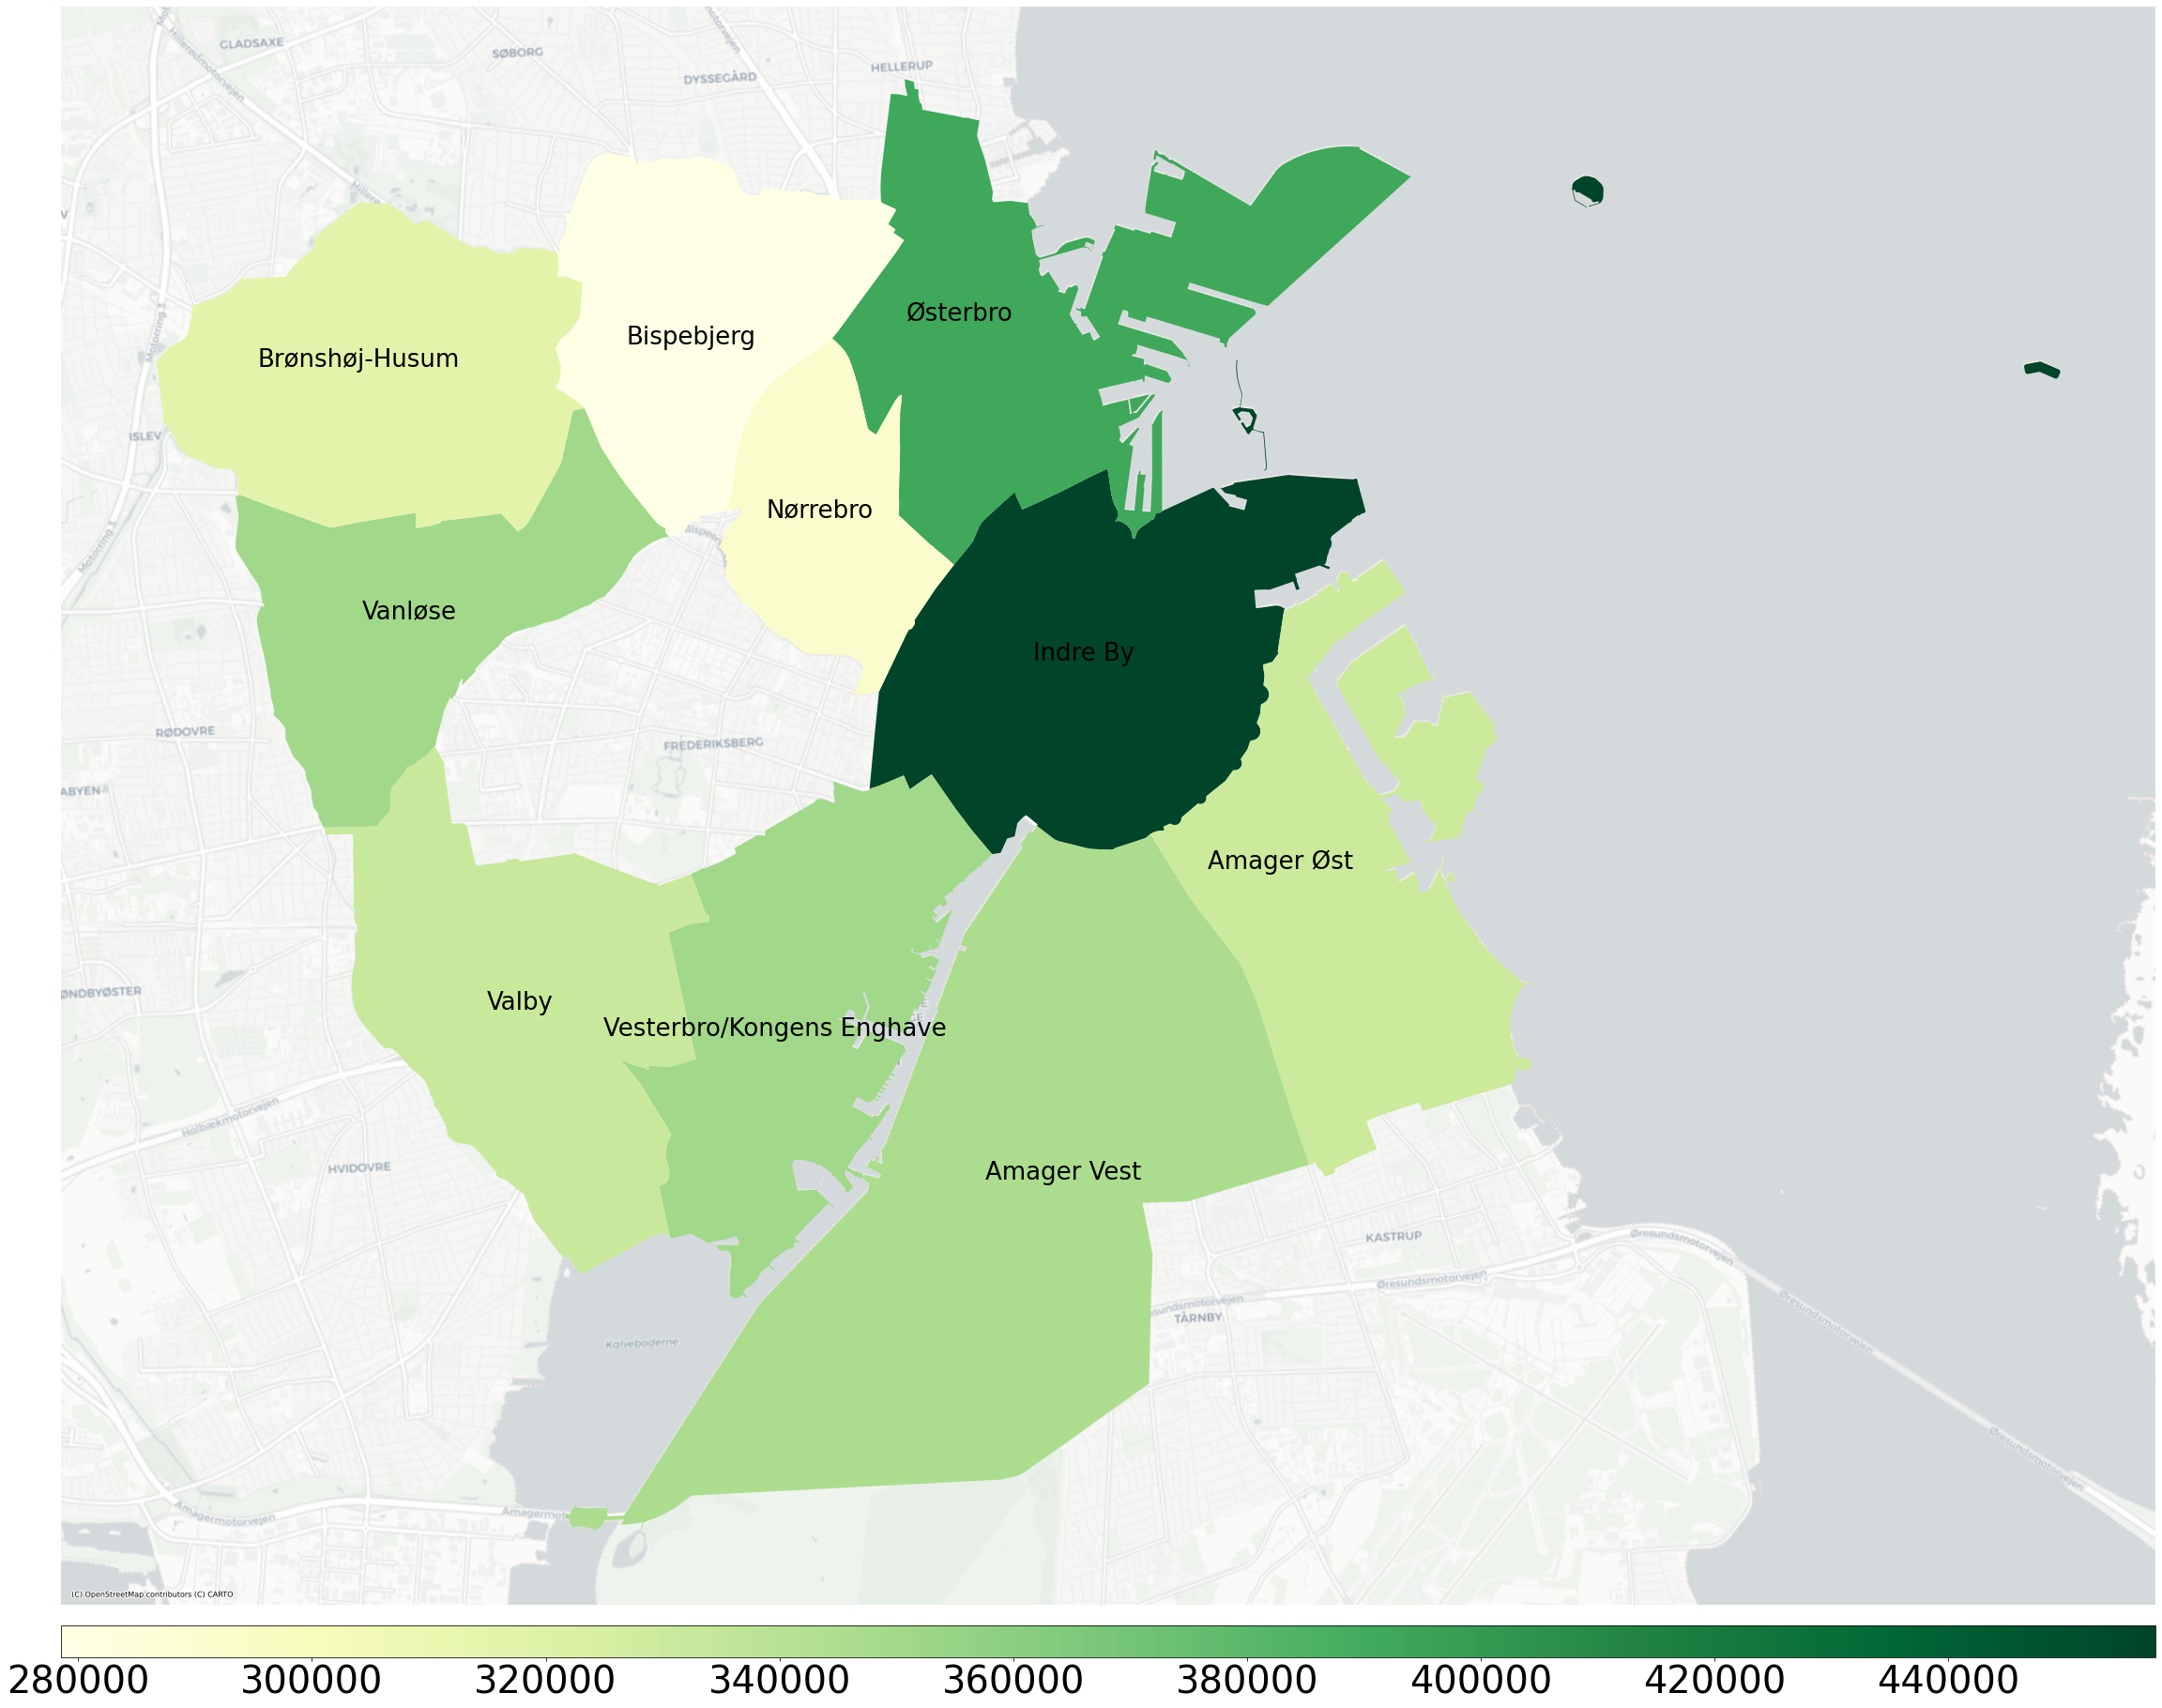

In [42]:
# Plot the geospatial data
fig, ax = plt.subplots(1, 1, figsize=(40, 40))

# Horisontally align the plot axes and the legend axes - https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2%", pad=0.3)

ax = df_income_geo_2019.plot(ax=ax,
                             #figsize=(50, 50),
                             column = 'avg_income',
                             legend=True,
                             cmap='YlGn',
                             cax=cax,
                             legend_kwds={'shrink': 0.5, 
                                          'orientation': "horizontal"}) # plot the district polygons using the geopandas plot method

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=df_income_geo_2019.crs) # add background map

ax.set_axis_off() # remove axes

fig = ax.figure

cb_ax = fig.axes[1]

cb_ax.tick_params(labelsize=40) # size of labels in the legend

# Add labels - https://stackoverflow.com/questions/38899190/geopandas-label-polygons
for idx, row in df_income_geo_2019.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['district'], horizontalalignment='center', size=26)
